# Recommender Systems with Surprise
- **Created by Andrés Segura Tinoco**
- **Created on May 27, 2019**

## Tune algorithm parameters
- Model built from a Pandas dataframe
- The algorithm used is: Singular Value Decomposition (SVD)
- Model trained using train and test datasets (80/20) and cross-validation
- The RMSE and MAE metrics were used to estimate the model error
- Type of filtering: collaborative

In [1]:
# Load the Python libraries
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
# Load Surprise libraries
from surprise import SVD
from surprise import Reader
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import GridSearchCV

In [3]:
# Load plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Path to dataset file
file_path = os.path.expanduser('../data/u.data')

# Read current ratings of the users
rawdata = pd.read_csv(file_path, sep = '\t', names = ['user_id','item_id','rating','timestamp'])
rawdata.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


## 1. Manual Tune

In [5]:
# Split data in training and test
train_data, test_data = train_test_split(rawdata, test_size = 0.2)
print("Train size:", train_data.shape)    # 80.00%
print("Test size:", test_data.shape)      # 20.00%

Train size: (80000, 4)
Test size: (20000, 4)


In [6]:
# Read the data into a Surprise dataset
reader = Reader(rating_scale = (1, 5))
data_train = Dataset.load_from_df(train_data[['user_id', 'item_id', 'rating']], reader)
data_test = Dataset.load_from_df(test_data[['user_id', 'item_id', 'rating']], reader)

In [7]:
# Build full trainset
data_train = data_train.build_full_trainset()
data_test = data_test.build_full_trainset()

# Create the trainset and testset
data_trainset = data_train.build_testset()
data_testset = data_test.build_testset()

In [8]:
# Plot the model RMSE
def plot_model_rmse(xs, ys, title, x_label, y_label):
    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize = (10, 5))
    ax.plot(xs, ys, marker = 'o')
    
    for x,y in zip(xs,ys):
        label = "{:.2f}".format(y)
        plt.annotate(label, (x,y), textcoords="offset points", xytext=(0,10), ha='center')
    
    plt.title(title, fontsize = 12)
    plt.xlabel(x_label, fontsize = 10)
    plt.ylabel(y_label, fontsize = 10)
    plt.draw()

**Number of factors (k)**

In [9]:
# Factors list
k_factors = [5, 10, 25, 50, 75, 100]

In [10]:
# CV results
train_rmse = []
test_rmse = []

# Loop in which errors are calculated
for k in k_factors:
    algo = SVD(n_factors=k, n_epochs=200, biased=True, lr_all=0.005, reg_all=0, init_mean=0, init_std_dev=0.01, verbose=False)
    algo.fit(data_train)
    
    # The error of the training data is calculated and saved
    predictions = algo.test(data_trainset)
    error = accuracy.rmse(predictions, verbose = False)
    train_rmse.append(error)
    
    # The error of the testing data is calculated and saved
    predictions_test = algo.test(data_testset)
    error = accuracy.rmse(predictions_test, verbose = False)
    test_rmse.append(error)

In [11]:
# Train RMSE dataframe
error_data = {'k': k_factors, 'error': train_rmse}
pd.DataFrame(error_data)

,k,error
0,5,0.751681
1,10,0.649910
2,25,0.423608
3,50,0.207601
4,75,0.095604
5,100,0.049740


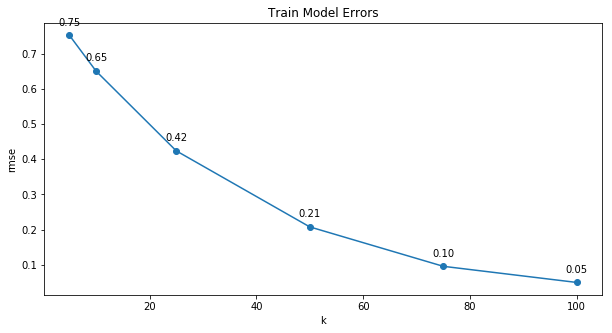

In [12]:
# Plotting the RMSE behaviour
plot_model_rmse(error_data['k'], error_data['error'], 'Train Model Errors', 'k', 'rmse')

In [13]:
# Test RMSE dataframe
error_data = {'k': k_factors, 'error': test_rmse}
pd.DataFrame(error_data)

,k,error
0,5,0.961386
1,10,1.023736
2,25,1.124988
3,50,1.148306
4,75,1.101355
5,100,1.058878


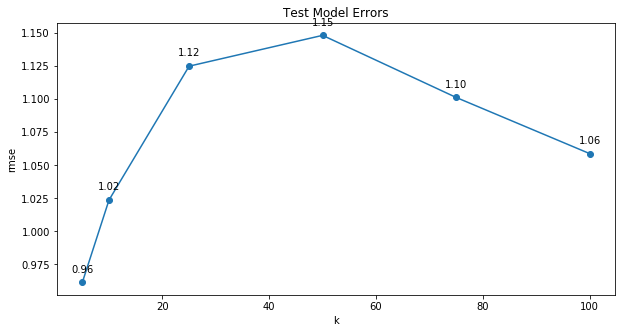

In [14]:
# Plotting the RMSE behaviour
plot_model_rmse(error_data['k'], error_data['error'], 'Test Model Errors', 'k', 'rmse')

**The regularization term for all parameters. Default is 0.02**

In [15]:
# Lista de valores de regularización
k = 5
reg_all = [0.01, 0.02, 0.05, 0.1, 0.5]

In [16]:
# CV results
train_rmse = []
test_rmse = []

# Loop in which errors are calculated
for reg in reg_all:
    algo = SVD(n_factors=k, n_epochs=200, biased=True, lr_all=0.005, reg_all=reg, init_mean=0, init_std_dev=0.01, verbose=False)
    algo.fit(data_train)
    
    # The error of the training data is calculated and saved
    predictions = algo.test(data_trainset)
    error = accuracy.rmse(predictions, verbose = False)
    train_rmse.append(error)
    
    # The error of the testing data is calculated and saved
    predictions_test = algo.test(data_testset)
    error = accuracy.rmse(predictions_test, verbose = False)
    test_rmse.append(error)

In [17]:
# Train RMSE dataframe
error_data = {'reg_all': reg_all, 'error': train_rmse}
pd.DataFrame(error_data)

,reg_all,error
0,0.01,0.753285
1,0.02,0.755786
2,0.05,0.770767
3,0.10,0.804400
4,0.50,0.938517


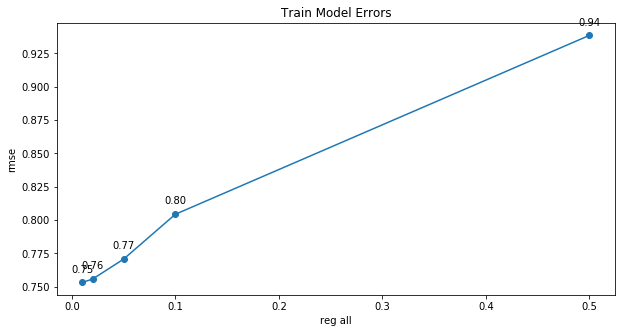

In [18]:
# Plotting the RMSE behaviour
plot_model_rmse(error_data['reg_all'], error_data['error'], 'Train Model Errors', 'reg all', 'rmse')

In [19]:
# Test RMSE dataframe
error_data = {'reg_all': reg_all, 'error': test_rmse}
pd.DataFrame(error_data)

,reg_all,error
0,0.01,0.952085
1,0.02,0.948223
2,0.05,0.929292
3,0.10,0.911361
4,0.50,0.961023


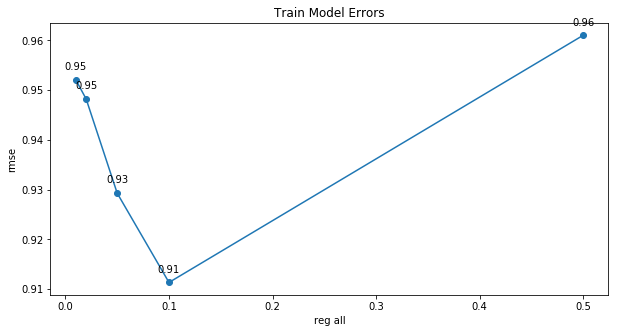

In [20]:
# Plotting the RMSE behaviour
plot_model_rmse(error_data['reg_all'], error_data['error'], 'Train Model Errors', 'reg all', 'rmse')

## 2. Auto Tune

The **GridSearchCV** class computes accuracy metrics for an algorithm on various combinations of parameters, over a cross-validation procedure. This is useful for finding the best set of parameters for a prediction algorithm.

In [21]:
# Read the raw data into a Surprise dataset
reader = Reader(rating_scale = (1, 5))
dataset = Dataset.load_from_df(rawdata[['user_id', 'item_id', 'rating']], reader)

In [22]:
# SVD params: 3 * 3 * 3 * 3 combinations
param_grid = {'n_factors': [5, 10, 20],
              'n_epochs': [20, 30, 50],
              'lr_all': [0.002, 0.005, 0.01],
              'reg_all': [0.02, 0.05, 0.1]}

In [23]:
# Tune algorithm parameters with GridSearchCV
gs = GridSearchCV(SVD, param_grid, measures = ['rmse', 'mae'], cv = 4)
gs.fit(dataset)

In [24]:
# Best RMSE and MAE scores
print(gs.best_score)

{'rmse': 0.9175544024140672, 'mae': 0.7235628893565583}


In [25]:
# Combination of parameters that gave the best scores
print(gs.best_params)

{'rmse': {'n_factors': 20, 'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.1}, 'mae': {'n_factors': 20, 'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.1}}


---
<a href="https://ansegura7.github.io/RS_Surprise/">&laquo; Home</a>